# Forward Propagation Code for a Sphere


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [ ]:
# class Beam:
    
#     ## Physical constants
#     h = 6.6260701e-34    # J.s: Planck's constant
#     c = 2.99792458e8     # m/s: Speed of light
    
#     def __init__(self, energy = 9.61306e-16, distance = 100e-3):
#         self.energy     = energy       # [J]
#         self.wavelength = h*c/self.E   # [m]
#         self.frequency  = self.E/h     # [Hz]
#         self.distance   = distance     # [m]
    
#     def get_planewave(self, K, nbins_x, nbins_y, z0 = 0.):
#         '''
#         Returns an array of the plane wave sampled at nbins_x * nbins_y points.
#         Args:
#             K   (complex): complex refractive index
#             nbins_x (int): number of bins in the x direction
#             nbins_y (int): number of bins in the y direction
#             z0    (float): initial beam position w.r.t. origin
#         returns:
#             planewave (ndarray): plane wave array of size nbins_x * nbins_y
#         '''
#         wave = np.exp(1j * K.real * z0)
#         planewave = np.full((nbins_x+1,nbins_y+1), wave, dtype = np.complex128)
#         return planewave

In [ ]:
# class absorber(self):
    
#     shapes = ['sphere', 'cylinder']
    
#     def __init__(self, shape, angles = [0.,0.,0.]):
#         self.shape  = shape
#         self.angles = angles
        

In [228]:
def SphericalThickness(r,x,y):
    '''
    Returns thickness through sphere of radius r at a given (x,y)
    '''
    if x**2 + y**2 < r**2:
        return np.sqrt(r**2 - (x**2 + y**2)) * 2
    else:
        return 0.


def SphericalAttenuation_pw(E, delta, beta, r, Lx, Ly, nbins_x, nbins_y):
    '''
    Inputs:
        E       (float): incident beam energy
        delta   (float): 1 + real part of refractive index
        beta    (float): imaginary part of refractive index
        r       (float): radius
        Lx      (float): image field x-length
        Ly      (float): image field y-length
        nbins_x (int)  : number of x bins
        nbins_y (int)  : number of y bins
    Outputs:
        attenuated_wave (ndarray): xy grid of waveform values post-attenuation
    '''
    ## Physical constants
    h = 6.6260701e-34    # [J.s]: Planck's constant
    c = 2.99792458e8     # [m/s]: Speed of light

    ## Material-specific constants
    N = 1 - delta + 1j*beta     # Complex refractive index
    lambda0 = h*c/E             # [1/m]: Vacuum wavelength
    K = (2*np.pi/lambda0) * N   # [1/m]: Complex wavevector

    ## Discretization parameters
    dx = Lx/nbins_x      # Spacing between x grid-points
    dy = Ly/nbins_y      # Spacing between y grid-points

    
    ## Initialize the attenuated wave as a uniform plane wave in the z direction starting at z = -2r
    attenuated_wave = np.full((nbins_x+1,nbins_y+1), np.exp(1j * N.real * (-2*radius)), dtype = np.complex128)
    attenuated_wave = np.full((nbins_x+1,nbins_y+1), np.exp(1j * K.real * (-2*radius)), dtype = np.complex128)

    ## Multiply the wave in each grid-point by the appropriate attenuation factor
    for i in range(nbins_x + 1):
        x = (i - nbins_x/2) * dx       # maps index i to coordinate x
        for j in range(nbins_y + 1):
            y = (j - nbins_y/2) * dy       # maps index j to coordinate y
            t = SphericalThickness(r,x,y)    # sphere thickness at entry point (x,y)
            attenuated_wave[i,j] *= np.exp(-2*N.imag*t)    # multiply plane wave in each bin by attenuation factor
            attenuated_wave[i,j] *= np.exp(-2*K.imag*t)    # multiply plane wave in each bin by attenuation factor

    return attenuated_wave



def propagate(wave, E, d):
    '''
    Propagates a wave via convolution.
    Args:
        wave (ndarray): 2D array of the wave to be propagated
        E      (float): wave energy
        d      (float): distance to propagate the wave
    '''
    ## Physical constants
    h = 6.6260701e-34    # J.s: Planck's constant
    c = 2.99792458e8     # m/s: Speed of light

    ## Vacuum wavelength and wavevector
    l_vac = h*c/E            # [m]: wavelength
    k_vac = 2*np.pi/l_vac    # [1/m]: wavevector
    
    dim = attenuated_wave.shape

    filt = np.zeros((dim[0],dim[1]), dtype = np.complex128)
    for i in range(dim[0]):
        x = (i - nbins_x/2) * dx       # maps index i to coordinate x
        for j in range(dim[1]):
            y = (j - nbins_y/2) * dy       # maps index j to coordinate y
            filt[i][j] += np.exp(-1j * k_vac * (x**2 + y**2) / (2*d))

    
    ## Propagate the wave through convolution
    propagated_wave = (-1j*np.exp(1j*k_vac*d)/(l_vac*d)) * signal.convolve2d(filt, attenuated_wave)

    
    return propagated_wave

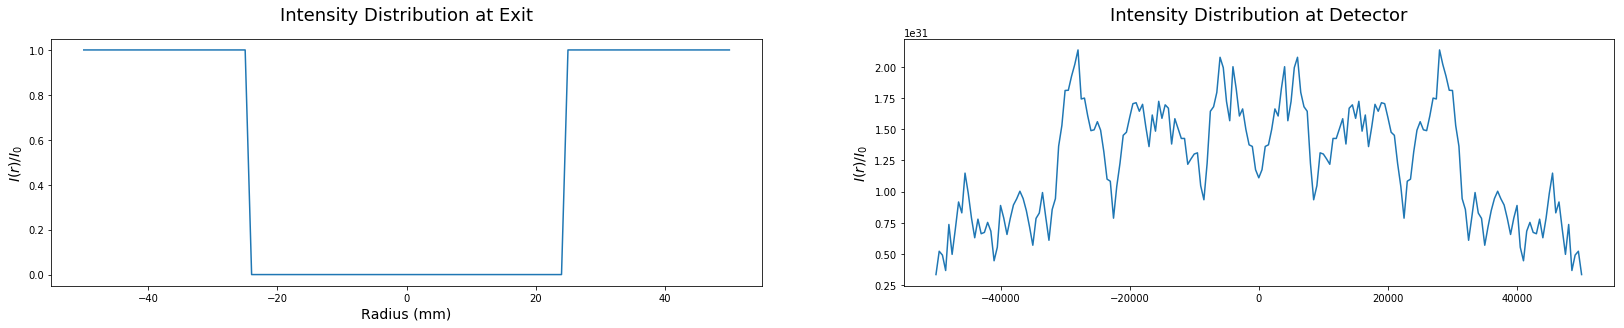

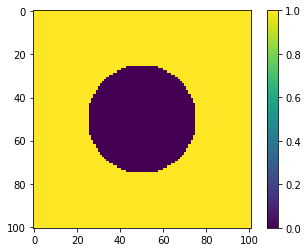

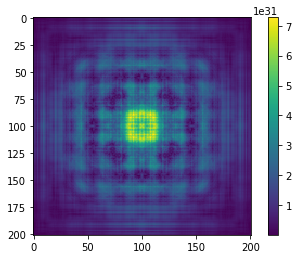

In [229]:
## Physical parameters
radius = 25e-3                # m: sphere radius
d      = 100e-3               # m: camera distance from edge of sphere
Lx     = 100e-3               # m: image field x-length
Ly     = 100e-3               # m: image field y-length
eV2J   = 1.60217662e-19       # [J/eV]
E0     = 5928.44775           # [keV]
# E0 = 9.61306e-16            # [J]: incident x-ray energy (= 6keV)

## Discretization parameters
nbins_x  = 100             # Number of x bins
nbins_y  = 100             # Number of y bins
dx       = Lx/nbins_x      # Spacing between x grid-points
dy       = Ly/nbins_y      # Spacing between y grid-points


attenuated_wave = SphericalAttenuation_pw(E0, delta, beta, radius, Lx, Ly, nbins_x, nbins_y)
propagated_wave = propagate(attenuated_wave, E0, d)

## Plotting
fig = plt.figure(figsize = (28,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

x = np.linspace(-nbins_x/2, nbins_x/2, dim[0]) * dx
ax1.plot(x * 1e3, np.abs(attenuated_wave[:,int(nbins_x/2)]))
ax1.set_xlabel('Radius (mm)', fontsize = 14)
ax1.set_ylabel('$I(r)/I_0$', fontsize = 14)
ax1.set_title('Intensity Distribution at Exit', fontsize = 18, y = 1.05)

x = np.linspace(-nbins_x/2, nbins_x/2, dim[0]*2-1)
ax2.plot(x * 1e3, np.abs(propagated_wave[:,int(nbins_x/2)]))
# ax2.set_xlabel('Radius (mm)', fontsize = 14)
ax2.set_ylabel('$I(r)/I_0$', fontsize = 14)
ax2.set_title('Intensity Distribution at Detector', fontsize = 18, y = 1.05)

plt.show()


plt.imshow(np.abs(attenuated_wave))
plt.colorbar()
plt.show()

plt.imshow(np.abs(propagated_wave))
plt.colorbar()
plt.show()

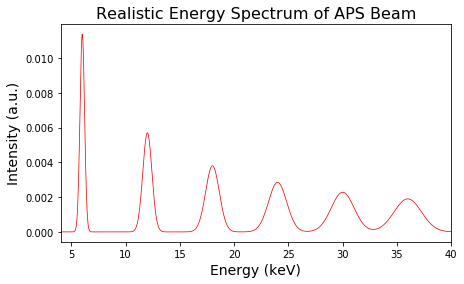

In [230]:
def gaussian(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp( -( ((x-mu)/sigma)**2 )/2)

def makeGaussianHarmonics(E0, N_harmonics, N_samples, E_lim = None, sigmas = None):
    ''' Returns a normalized intensity distribution of Gaussians
        centered at harmonics of E0.'''
    centroids = [i*E0 for i in range(1,N_harmonics+2)]

    if sigmas is None:
        sigmas = [0.035*E for E in centroids]

    if E_lim is None:
        energy_axis = np.linspace(E0 * 0.5, E0 * 1.5, N_samples)
    else:
        energy_axis = np.linspace(E_lim[0], E_lim[1], N_samples)
        
    beam_profile = 0
    for n,E in enumerate(centroids):
        beam_profile += gaussian(energy_axis, centroids[n], sigmas[n])

    beam_profile /= sum(beam_profile) # normalize the profile
    
    return [energy_axis, beam_profile]

E0 = 6.0
energy_axis, beam_profile = makeGaussianHarmonics(E0, 5, 1000, E_lim = [4.0,40.0])

fig = plt.figure(figsize = (7,4))
ax  = fig.add_subplot(111)
ax.plot(energy_axis, beam_profile, 'r-', lw = 0.75)
ax.set_xlim([4,40])
ax.set_xlabel('Energy (keV)', fontsize = 14)
ax.set_ylabel('Intensity (a.u.)', fontsize = 14)
ax.set_title('Realistic Energy Spectrum of APS Beam', fontsize = 16)
plt.savefig('APS_Spectrum.png')
plt.show()

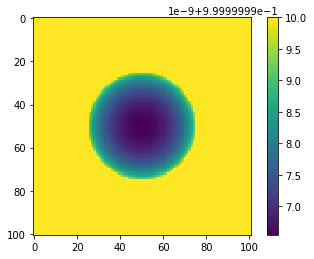

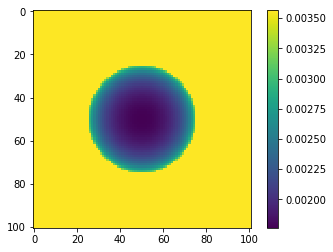

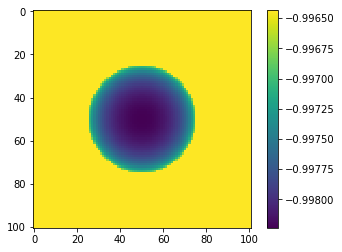

In [231]:
## Physical parameters
radius = 25e-3                # m: sphere radius
d      = 100e-3               # m: camera distance from edge of sphere
Lx     = 100e-3               # m: image field x-length
Ly     = 100e-3               # m: image field y-length
eV2J   = 1.60217662e-19       # [J/eV]
E0     = 5928.44775           # [keV]
# E0 = 9.61306e-16            # [J]: incident x-ray energy (= 6keV)

## Discretization parameters
nbins_x  = 100             # Number of x bins
nbins_y  = 100             # Number of y bins
dx       = Lx/nbins_x      # Spacing between x grid-points
dy       = Ly/nbins_y      # Spacing between y grid-points


energy_axis, beam_profile = makeGaussianHarmonics(E0 = E0, N_harmonics = 5, N_samples = 1000, E_lim = [4.0,40.0])
weighted_waves = [None] * len(energy_axis)

for i,E in enumerate(energy_axis):
    weighted_waves[i] = SphericalAttenuation_pw(E*eV2J, delta, beta, radius, Lx, Ly, nbins_x, nbins_y) * beam_profile[i]

full_wave = sum(weighted_waves)

plt.imshow(np.abs(aw))
plt.colorbar()
plt.show()

plt.imshow(np.abs(full_wave))
plt.colorbar()
plt.show()

plt.imshow(np.abs(full_wave) - np.abs(aw))
plt.colorbar()
plt.show()